### GW tutorial 2: Detector noise and GW150914

Author: Melissa Lopez

Email: m.lopez@uu.nl

Note that we are importing some packages to be able to read the data.

In [10]:
!pip install pycbc

import numpy as np
import matplotlib.pyplot as plt
from pycbc.catalog import Merger
import pycbc.psd
import pylab


In the previous part we have seen the detector response to gravitational waves (GW). Currently, we have three ground-based detectors: LIGO Hanford (H1), LIGO Livingston (L1) and Virgo (V1). But what does the data actually look like?

To answer this question we are going to take a look at the first detection: **GW150914**. Let's load the data from L1

In [11]:
m = Merger('GW150914')
ifo = 'L1'
data = m.strain(ifo)

**Exercise 1:** We can see that this object is a PyCBC timeseries, and as such you can check what their atributes are (see [here](https://pycbc.org/pycbc/latest/html/pycbc.types.html#module-pycbc.types.timeseries)). Let's check some of them.

- How much is the duration of the time series?

- How much is its sampling rate?

- How many data points does it have?

- How much is $\Delta_{f}$ and $\Delta_{t}$? Can you find a relation between these and the number of data points?

_Hint:_ $\Delta_{f} = 1/duration$ and  $\Delta_{t} = 1/sample\_rate$

In [12]:
# Get the duration of the time series
duration = data.duration

# Get the sampling rate
sampling_rate = data.sample_rate

# Calculate the number of data points
num_data_points = len(data)

# Calculate frequency and time resolution
delta_f = 1 / duration
delta_t = 1 / sampling_rate

# Print results
print(f"Duration of time series: {duration} seconds")
print(f"Sampling rate: {sampling_rate} Hz")
print(f"Number of data points: {num_data_points}")
print(f"Δf (frequency resolution): {delta_f} Hz")
print(f"Δt (time resolution): {delta_t} seconds")

# Relationship between Δf, Δt, and number of data points
relation = duration * sampling_rate
print(f"Relation check (Duration * Sampling Rate): {relation} ≈ Number of data points: {num_data_points}")

Duration of time series: 32.0 seconds
Sampling rate: 4096.0 Hz
Number of data points: 131072
Δf (frequency resolution): 0.03125 Hz
Δt (time resolution): 0.000244140625 seconds
Relation check (Duration * Sampling Rate): 131072.0 ≈ Number of data points: 131072


The previous magnitudes are key parameters of the timeseries. Now, let's plot the actual data to see what it looks like.

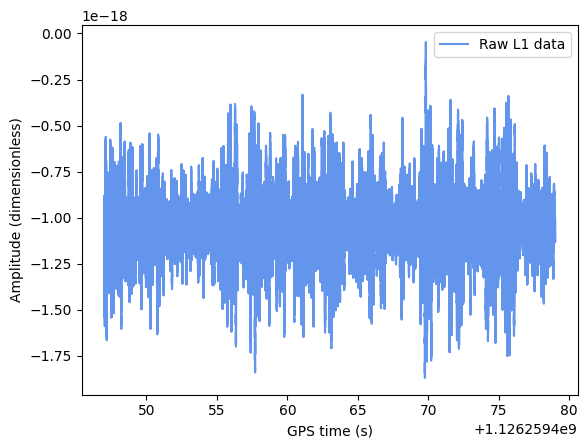

In [13]:
plt.plot(data.sample_times, data, label='Raw L1 data', color='cornflowerblue')
plt.xlabel('GPS time (s)')
plt.ylabel('Amplitude (dimensionless)')
plt.legend()

In GW we use the GPS time to determine at what time the GW signals reached Earth. You can see that the amplitude of this data is super small, $\mathcal{O}(10^{-18})$! GW interferometers are able to detect a change in distance of ~1/10,000th the size of a proton.

But, where is GW190514? We cannot see it (yet) as there are many different contributions from the detector. The detector has a given "noise budget" given  by the power spectral density (PSD), $S_{n}(f)$, according to its specific design.

**Exercise 2**: Estimate the PSD of the data using `filter_psd` (see [here](https://pycbc.org/pycbc/latest/html/pycbc.types.html#pycbc.types.timeseries.TimeSeries.filter_psd)) and plot it. Limit your plot according to the minimum frequency (say, 1 Hz) and  the Nyquist frequency.

_Hint_: Note that the PSD is a frequency series.

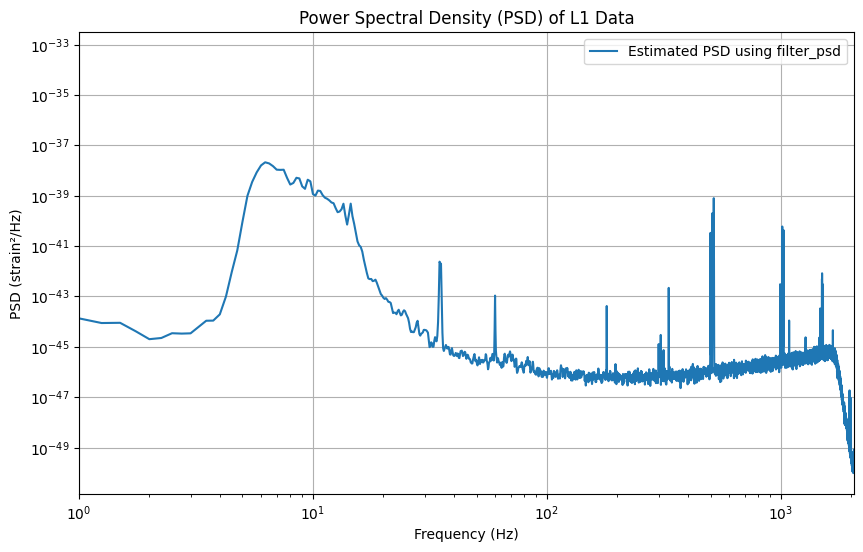

In [14]:
# Define parameters
segment_duration = 4  # Segment duration in seconds
delta_f = 1.0 / segment_duration  # Frequency resolution
flow = 1.0  # Low-frequency cutoff

# Estimate the PSD using filter_psd
psd = data.filter_psd(segment_duration, delta_f, flow)

# Create a frequency array
freqs = np.arange(0, len(psd) * delta_f, delta_f)

# Plot the PSD (Power Spectral Density)
plt.figure(figsize=(10, 6))
plt.loglog(freqs, psd, label='Estimated PSD using filter_psd')
plt.xlim(1, data.sample_rate / 2)  # Limit frequency range from 1 Hz to Nyquist
plt.xlabel('Frequency (Hz)')
plt.ylabel('PSD (strain²/Hz)')
plt.title('Power Spectral Density (PSD) of L1 Data')
plt.legend()
plt.grid()
plt.show()

The PSD shows us what are the different contributions of the detector noise.
While we computed the PSD from 1 Hz, you can see that there is a weird behaviour for frequencies < 5 Hz. This is because the detector is not calibrated at these frequencies, so our analysis needs to start at higher frequencies. For current ground based detectors, we usually start at 10 Hz or higher, depending on the source.

GW signals are tiny, so with this much noise we won't be able to see GW150914. To "flatten" all frequency contributions we whiten the data.

**Exercise 3:** We can whiten the data with [this](https://pycbc.org/pycbc/latest/html/pycbc.types.html#pycbc.types.timeseries.TimeSeries.whiten) function. Use `segment_duration = 4` and `max_filter_duration=4`.

- Plot the whitened data next to the raw detector noise. What differences can you see?

- Estimate the PSD of the whitened data. Plot it in the same graph as the raw PSD. What differences can you see?


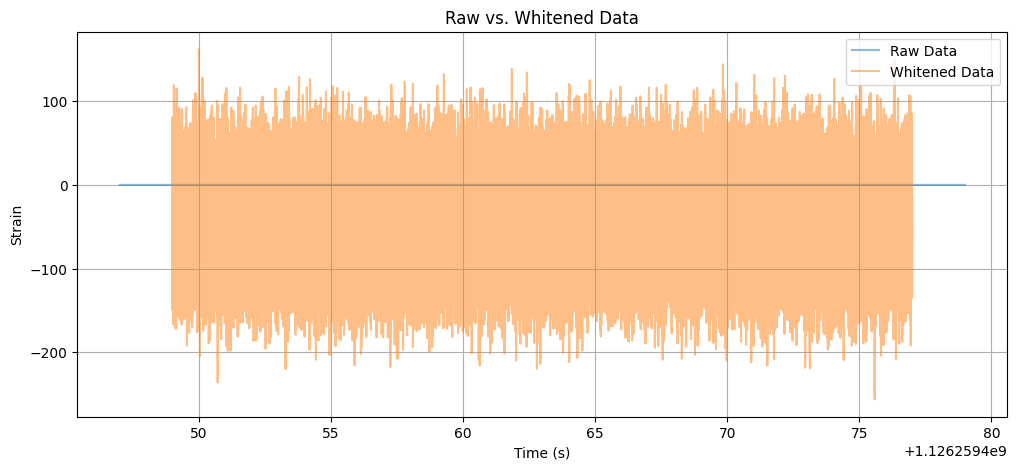

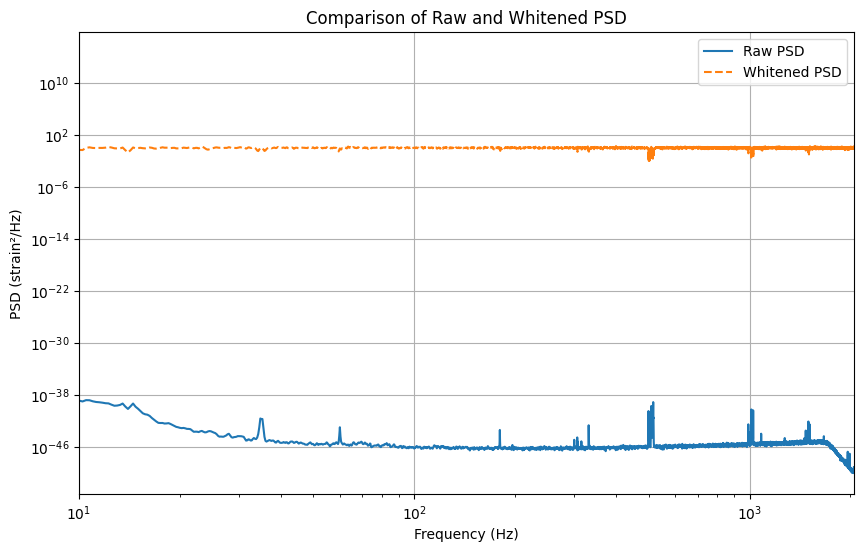

In [15]:
# Define parameters
segment_duration = 4  # Segment duration in seconds
delta_f = 1.0 / segment_duration  # Frequency resolution
flow = 10.0  # Low-frequency cutoff (starting at 10Hz to avoid calibration issues)

# Estimate the raw PSD using filter_psd
psd_raw = data.filter_psd(segment_duration, delta_f, flow)

# Whiten the data (without providing PSD explicitly)
whitened_data = data.whiten(segment_duration=4, max_filter_duration=4)

# Plot the raw and whitened data
plt.figure(figsize=(12, 5))
plt.plot(data.sample_times, data, alpha=0.5, label='Raw Data')
plt.plot(whitened_data.sample_times, whitened_data, alpha=0.5, label='Whitened Data')
plt.xlabel('Time (s)')
plt.ylabel('Strain')
plt.title('Raw vs. Whitened Data')
plt.legend()
plt.grid()
plt.show()

# Compute the PSD of the whitened data
psd_whitened = whitened_data.filter_psd(segment_duration, delta_f, flow)

# Create frequency array
freqs = np.arange(0, len(psd_raw) * delta_f, delta_f)

# Plot the raw and whitened PSD together
plt.figure(figsize=(10, 6))
plt.loglog(freqs, psd_raw, label='Raw PSD')
plt.loglog(freqs, psd_whitened, label='Whitened PSD', linestyle='dashed')
plt.xlim(10, data.sample_rate / 2)  # Limit frequency range from 10 Hz to Nyquist
plt.xlabel('Frequency (Hz)')
plt.ylabel('PSD (strain²/Hz)')
plt.title('Comparison of Raw and Whitened PSD')
plt.legend()
plt.grid()
plt.show()

Now all frequency contributions are at the same level, as we can see from the PSD. However, GW150914 is still hidden in the data.


**Exercise 4:** We can apply a [low pass filter](https://pycbc.org/pycbc/latest/html/pycbc.types.html#pycbc.types.timeseries.TimeSeries.lowpass_fir) and a [high pass filter](https://pycbc.org/pycbc/latest/html/pycbc.types.html#pycbc.types.timeseries.TimeSeries.highpass_fir) to limit the frequency of the data. The low pass filters above 250 Hz (order=512) and the high pass filters below 30 Hz (order=512).

- Estimate the PSD of the bandpassed data and plot it together with the raw PSD and the whitened PSD. What is the bandpass doing?

- Plot the bandpassed data [cropping](https://pycbc.org/pycbc/latest/html/pycbc.types.html#pycbc.types.timeseries.TimeSeries.crop) 12s on the left and 13s on the right. What can you see? Compare this to the raw data. What frequencies dominate in each case?

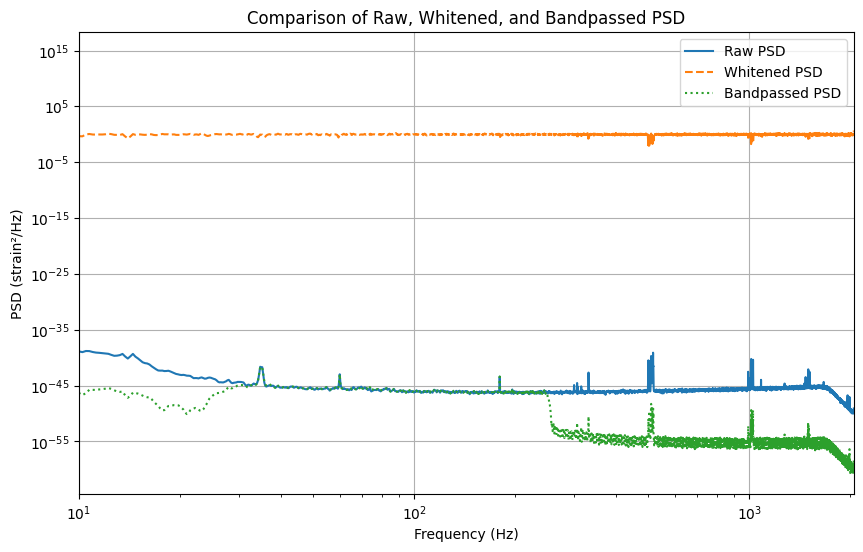

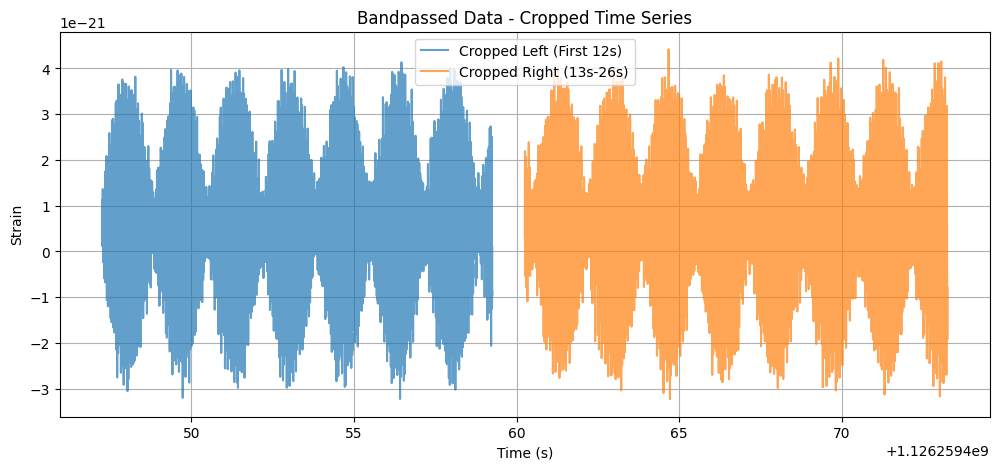

In [16]:
# Define parameters
segment_duration = 4  # Segment duration in seconds
delta_f = 1.0 / segment_duration  # Frequency resolution
flow = 10.0  # Low-frequency cutoff

# Apply a bandpass filter (High-pass above 30Hz, Low-pass below 250Hz)
bandpassed_data = data.lowpass_fir(250, order=512).highpass_fir(30, order=512)

# Compute PSDs
psd_raw = data.filter_psd(segment_duration, delta_f, flow)
whitened_data = data.whiten(segment_duration=4, max_filter_duration=4)
psd_whitened = whitened_data.filter_psd(segment_duration, delta_f, flow)
psd_bandpassed = bandpassed_data.filter_psd(segment_duration, delta_f, flow)

# Create a frequency array
freqs = np.arange(0, len(psd_raw) * delta_f, delta_f)

# Plot the PSDs together
plt.figure(figsize=(10, 6))
plt.loglog(freqs, psd_raw, label='Raw PSD')
plt.loglog(freqs, psd_whitened, label='Whitened PSD', linestyle='dashed')
plt.loglog(freqs, psd_bandpassed, label='Bandpassed PSD', linestyle='dotted')
plt.xlim(10, data.sample_rate / 2)  # Limit frequency range
plt.xlabel('Frequency (Hz)')
plt.ylabel('PSD (strain²/Hz)')
plt.title('Comparison of Raw, Whitened, and Bandpassed PSD')
plt.legend()
plt.grid()
plt.show()

# Fix: Use bandpassed_data.start_time instead of data.start_time
bandpass_start = bandpassed_data.start_time  # Corrected start time reference

# Crop the bandpassed data correctly
cropped_left = bandpassed_data.time_slice(bandpass_start, bandpass_start + 12)
cropped_right = bandpassed_data.time_slice(bandpass_start + 13, bandpass_start + 26)

# Plot the cropped time series
plt.figure(figsize=(12, 5))
plt.plot(cropped_left.sample_times, cropped_left, label='Cropped Left (First 12s)', alpha=0.7)
plt.plot(cropped_right.sample_times, cropped_right, label='Cropped Right (13s-26s)', alpha=0.7)
plt.xlabel('Time (s)')
plt.ylabel('Strain')
plt.title('Bandpassed Data - Cropped Time Series')
plt.legend()
plt.grid()
plt.show()

**Exercise 5:** Last but not least, we generate a spectrogram (time-frequency representation) using [this](https://pycbc.org/pycbc/latest/html/pycbc.types.html#pycbc.types.timeseries.TimeSeries.qtransform) function.

_Hint_: logfsteps=200, qrange=(110, 110), frange=(20, 512), vmax=3.5 as it is standard

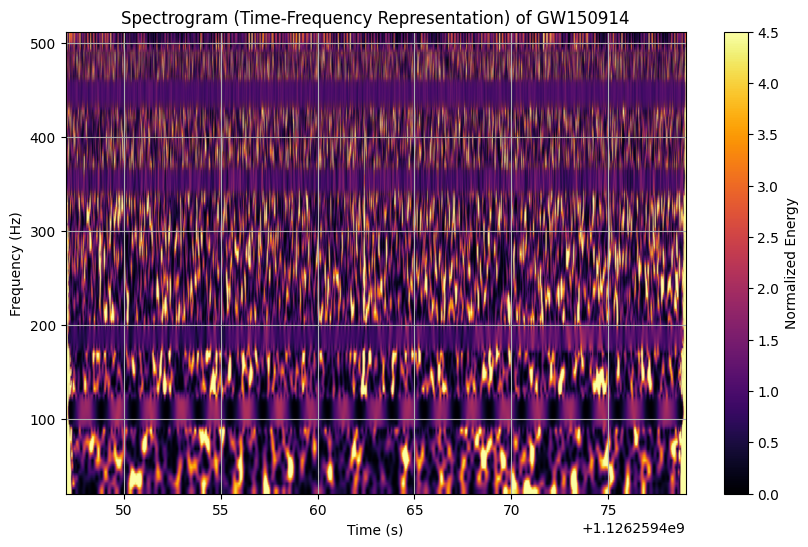

In [17]:
# Define spectrogram parameters
logfsteps = 200  # Number of log frequency bins
qrange = (10, 110)  # Quality factor range
frange = (20, 512)  # Frequency range in Hz
vmax = 4.5  # Standard scaling parameter

# Generate the spectrogram
plt.figure(figsize=(10, 6))
t, f, S = data.qtransform(frange=frange, qrange=qrange, logfsteps=logfsteps)

# Display the spectrogram using imshow()
pylab.imshow(S, aspect='auto', extent=[t[0], t[-1], f[0], f[-1]],
             origin='lower', vmin=0, vmax=vmax, cmap='inferno')

# Add labels and title
plt.title('Spectrogram (Time-Frequency Representation) of GW150914')
plt.xlabel('Time (s)')
plt.ylabel('Frequency (Hz)')
plt.colorbar(label="Normalized Energy")
plt.grid()
plt.show()

As we have seen, the detector has a given "noise budget" given  by the power spectral density (PSD), $S_{n}(f)$, according to its specific design. Let's see how the detectors will improve in the next observing runs.

**Bonus track:** From the `sensitivity_curves` folder [load](https://pycbc.org/pycbc/latest/html/pycbc.psd.html#pycbc.psd.read.from_txt) the PSD s:

- Third observing run of H1: `aligo_O3actual_H1.txt`
- Third observing run of L1: `aligo_O3actual_L1.txt`
- Third observing run of V1: `avirgo_O3actual.txt`
- Simulated fourth observing run of LIGO: `aligo_O4high.txt`

Note that these PSDs are from [LIGO public website](https://dcc.ligo.org/ligo-t2000012/public). Also read the PSD of [Einstein Telescope](https://pycbc.org/pycbc/latest/html/pycbc.psd.html#pycbc.psd.analytical.EinsteinTelescopeP1600143) (ET) and [Cosmic Explorer](https://pycbc.org/pycbc/latest/html/pycbc.psd.html#pycbc.psd.analytical.CosmicExplorerP1600143) (CE)

Plot all these PSDs. What can you say about ET and CE improvements?

_Hint_: Minimum frequency is 10 Hz, sampling rate 8192 Hz and duration is 16s.


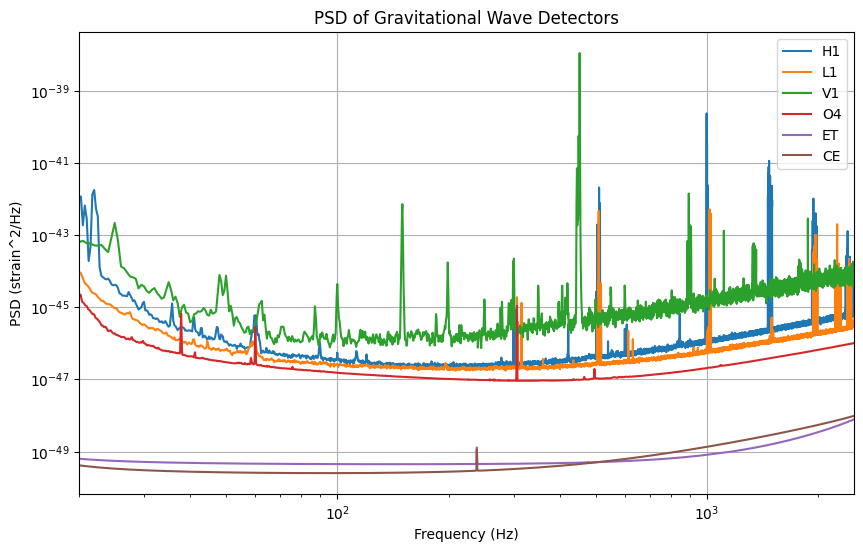

In [20]:
# Define the file paths for the PSD files you want to use
files = {
    'H1': 'aligo_O3actual_H1.txt',
    'L1': 'aligo_O3actual_L1.txt',
    'V1': 'avirgo_O3actual.txt',
    'O4': 'aligo_O4high.txt',
}

# Set parameters for PSD reading
duration = 16  # duration in seconds
delta_f = 1 / duration  # frequency resolution
sampleRate = 4995  # Adjusted to the highest available frequency in your data
length = sampleRate * duration  # length in samples
low_frequency = 20  # Set a higher minimum frequency (e.g., 20 Hz)

# Loop for reading all the files and extracting the data
psd_data = {}
for key, filename in files.items():
    psd_data[key] = pycbc.psd.read.from_txt(filename, length=length, delta_f=delta_f, low_freq_cutoff=low_frequency)

# Get the PSD values for the ET and CE functions
psd_ET = pycbc.psd.analytical.CosmicExplorerWidebandP1600143(length, delta_f, low_frequency)
psd_CE = pycbc.psd.analytical.CosmicExplorerP1600143(length, delta_f, low_frequency)

# Plotting the PSDs
plt.figure(figsize=(10, 6))

# Loop for plotting the data from the input files
for key, psd in psd_data.items():
    plt.loglog(psd.sample_frequencies, psd, label=key)

# Plot the data for the ET and CE functions
plt.loglog(psd_ET.sample_frequencies, psd_ET, label="ET")
plt.loglog(psd_CE.sample_frequencies, psd_CE, label="CE")

# Set plot labels and title
plt.title('PSD of Gravitational Wave Detectors')
plt.xlabel('Frequency (Hz)')
plt.ylabel('PSD (strain^2/Hz)')
plt.xlim(low_frequency, sampleRate / 2)  # Limit frequency range
plt.legend()
plt.grid()
plt.show()

Good job! This is the end of the second part. Maybe you can go for a break?